In [2]:
!python -m pip install tensorflow  matplotlib tensorflow-datasets ipywidgets

  Using cached wrapt-1.14.1-cp310-cp310-win_amd64.whl (35 kB)
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0


In [3]:
!pip list

Package                      Version
---------------------------- ---------------------
absl-py                      1.4.0
anyio                        4.1.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
array-record                 0.4.1
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.13.1
beautifulsoup4               4.12.2
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
dm-tree                  

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
ds = tfds.load('fashion_mnist', split='train')

In [6]:
import numpy as np
from matplotlib import pyplot as plt
dataiterator = ds.as_numpy_iterator()

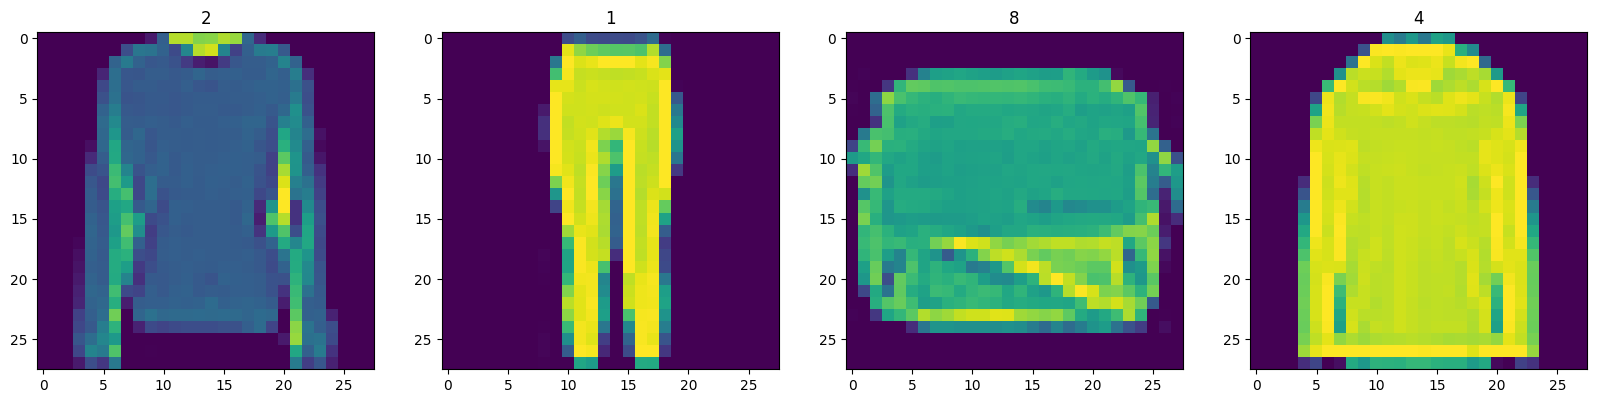

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image'])) 
    ax[idx].title.set_text(sample['label'])

In [8]:
def scale_image(data):
    image = data["image"]
    return image/255

In [9]:
ds = ds.map(scale_image) 
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [12]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1,4,padding="same",activation="sigmoid"))
    
    return model

In [13]:
test_model = build_generator()

In [14]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [20]:
img=test_model.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 472ms/step


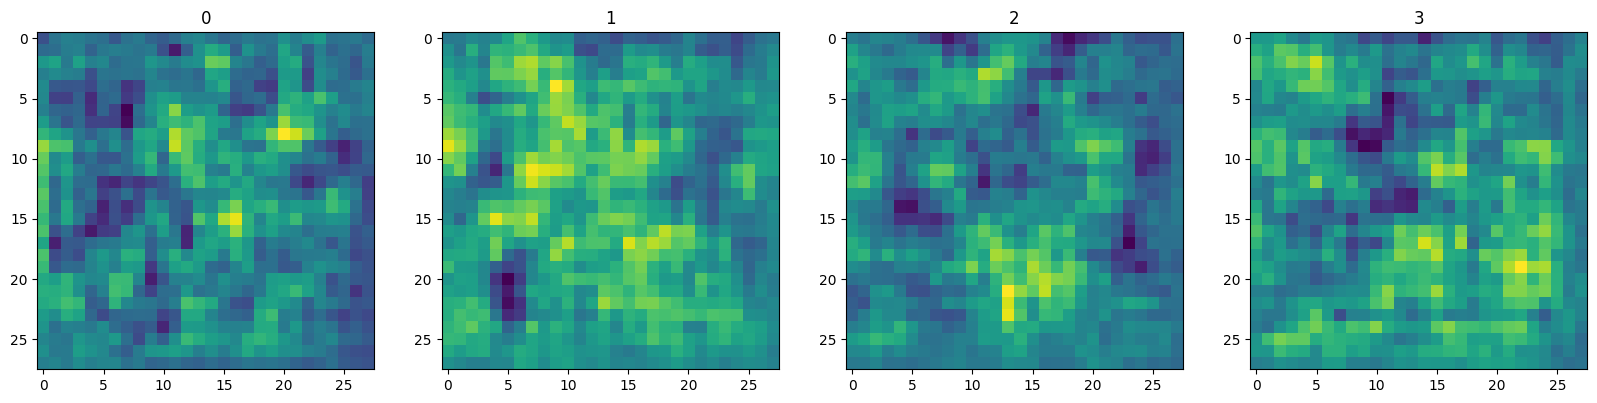

In [15]:
img=test_model.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(img): 
    
    ax[idx].imshow(np.squeeze(img)) 
    ax[idx].title.set_text(idx)

In [16]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32,5,input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation="sigmoid"))
    
    return model

In [17]:
descriminator = build_discriminator()

In [18]:
descriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [21]:
descriminator.predict(img)

1/1 [==============================] - 0s 231ms/step


array([[0.47856927],
       [0.47854543],
       [0.4782599 ],
       [0.4783665 ]], dtype=float32)

In [22]:
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import BinaryCrossentropy